<h1>Caso Practico - Aprendizaje Automático</h1>

* Wagner Salazar
* Stefy Franco
* Gustavo Larriva
* Angel

In [2]:
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Carga

In [3]:
df_data = pd.read_csv("./online_shoppers_intention.csv")
print(f"Se cargo correctamente un DataFrame con {df_data.shape[0]} registros y {df_data.shape[1]} columnas")

Se cargo correctamente un DataFrame con 12330 registros y 18 columnas


# Exploración

## Nulos

In [4]:
print(df_data.isna().sum())
print("\n")
print("Por instrucción del caso se deben eliminar los valores nulos del dataset.")
df_data.dropna(inplace=True)

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64


Por instrucción del caso se deben eliminar los valores nulos del dataset.


## Revisión variables categóricas

Se parte la exploración de los datos desde las variables categóricas ya que es más sencillo verificar su coherencia

In [5]:
categorical_col = ["Month", "OperatingSystems", "Browser", "Region", "TrafficType", "VisitorType", "Weekend", "Revenue"]
for col in df_data[categorical_col].columns:
    print(f"{col}")
    print(f"Categorías: {df_data[col].unique()}")
    print("------------------")

Month
Categorías: ['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']
------------------
OperatingSystems
Categorías: [1 2 4 3 7 6 8 5]
------------------
Browser
Categorías: [ 1  2  3  4  5  6  7 10  8  9 12 13 11]
------------------
Region
Categorías: [1 9 2 3 4 5 6 7 8]
------------------
TrafficType
Categorías: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 16 17 20]
------------------
VisitorType
Categorías: ['Returning_Visitor' 'New_Visitor' 'Other']
------------------
Weekend
Categorías: [False  True]
------------------
Revenue
Categorías: [False  True]
------------------


### Months
* Estandarizar junio June => Jun
* Es necesario establecer un órden para la categoría
* Convertir en categorical

In [6]:
df_data["Month"] = np.where(df_data["Month"] == "June", "Jun", df_data["Month"])
months = ['Feb', 'Mar', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_data["Month"] = pd.Categorical(df_data["Month"], categories=months, ordered=True)

No es necesario revisar el resto de variables categóricas. Ya que no tienen valores nulos y sus clasificaciones corresponde al tipo de varible explicada. A continuación se convierten las variables categóricas en categorical con un orden lógico para las variables con enteros, los object .

In [7]:
for col in categorical_col[1:]:
    # print(df_data[col].dtype)
    if (df_data[col].dtype == "int64"):
        min = df_data[col].min()
        max = df_data[col].max()
        order = np.arange(min, max+1)
        df_data[col] = pd.Categorical(df_data[col], categories=order, ordered=True)
    elif (df_data[col].dtype == "object"):
        df_data[col] = pd.Categorical(df_data[col], categories=df_data[col].unique())

In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           12316 non-null  float64 
 1   Administrative_Duration  12316 non-null  float64 
 2   Informational            12316 non-null  float64 
 3   Informational_Duration   12316 non-null  float64 
 4   ProductRelated           12316 non-null  float64 
 5   ProductRelated_Duration  12316 non-null  float64 
 6   BounceRates              12316 non-null  float64 
 7   ExitRates                12316 non-null  float64 
 8   PageValues               12316 non-null  float64 
 9   SpecialDay               12316 non-null  float64 
 10  Month                    12316 non-null  category
 11  OperatingSystems         12316 non-null  category
 12  Browser                  12316 non-null  category
 13  Region                   12316 non-null  category
 14  TrafficType

## Información transaccional
El objetivo del análisis exploratorio es determinar que variables guaradan un correlación fuerte con las visitas al aplicativo web que concluyeron en una venta. Se analizan las variables obtenidas desde el sistema transaccional en dos grupos: 
* Interacciones por tipo de página
    * Administrative
    * Informational
    * ProductRelated
* Duración de las interaciones por tipo de página
    * Administrative_Duration
    * Informational_Duration
    * ProductRelated_Duration

Las variables detalladas arriba se clasificaran contra **Revenue**. Ya está determina si el cliente realizó una compra o no.

### Promedio de interacciones por tipo de página

In [9]:
df_temp_1 = df_data.groupby(by=["Revenue"])[["Administrative", "Informational", "ProductRelated"]].mean().reset_index()
df_temp_1["Revenue"] = np.where(df_temp_1["Revenue"]==True, "Comprador", "No Comprador")
df_temp_1 = df_temp_1.melt(id_vars=["Revenue"], value_vars=["Administrative", "Informational", "ProductRelated"], var_name="TipoPagina", value_name="Value")
df_temp_1 = df_temp_1.sort_values(by=["Revenue", "TipoPagina", "Value"])
display(df_temp_1)

,Revenue,TipoPagina,Value
1,Comprador,Administrative,3.393606
3,Comprador,Informational,0.786164
5,Comprador,ProductRelated,48.210168
0,No Comprador,Administrative,2.120580
2,No Comprador,Informational,0.452248
4,No Comprador,ProductRelated,28.748943


### Promedio de duración de las interacciones por tipo de página

In [10]:
df_temp_2 = df_data.groupby(by=["Revenue"])[["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]].mean().reset_index()
df_temp_2["Revenue"] = np.where(df_temp_2["Revenue"]==True, "Comprador", "No Comprador")
df_temp_2 = df_temp_2.melt(id_vars=["Revenue"], value_vars=["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"], var_name="TipoPagina", value_name="TotalDuration")
df_temp_2 = df_temp_2.sort_values(by=["Revenue", "TipoPagina", "TotalDuration"])
display(df_temp_2)

,Revenue,TipoPagina,TotalDuration
1,Comprador,Administrative_Duration,119.483244
3,Comprador,Informational_Duration,57.611427
5,Comprador,ProductRelated_Duration,1876.209615
0,No Comprador,Administrative_Duration,73.834208
2,No Comprador,Informational_Duration,30.270759
4,No Comprador,ProductRelated_Duration,1071.347468


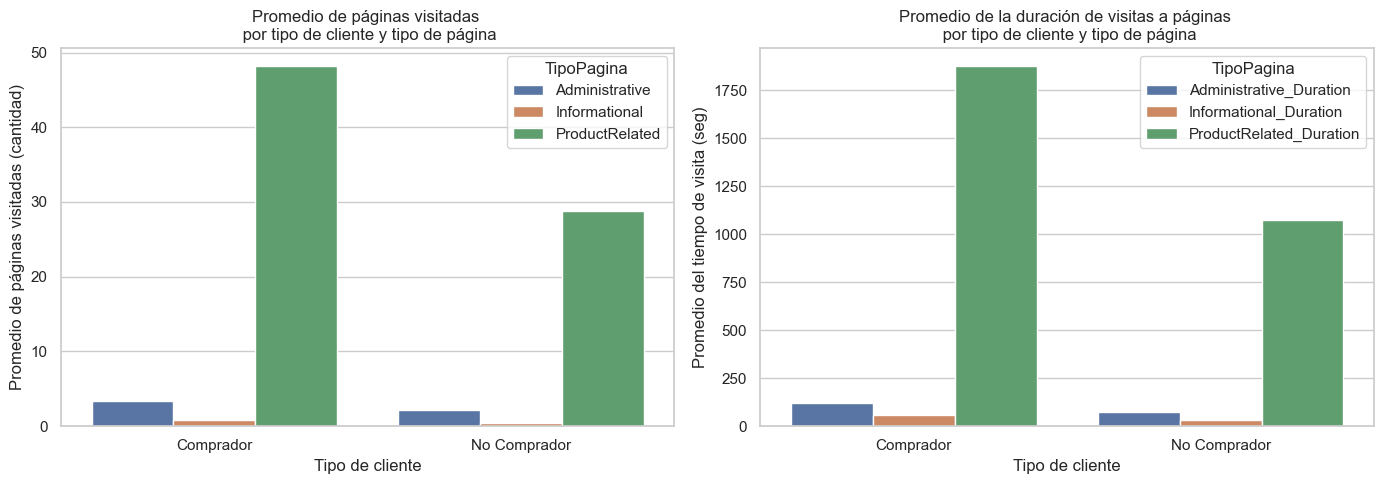

In [11]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(x="Revenue", y="Value", hue="TipoPagina", data=df_temp_1, ax=axes[0])
axes[0].set_xlabel("Tipo de cliente")
axes[0].set_ylabel("Promedio de páginas visitadas (cantidad)")
axes[0].set_title("Promedio de páginas visitadas \n por tipo de cliente y tipo de página")
sns.barplot(x="Revenue", y="TotalDuration", hue="TipoPagina", data=df_temp_2, ax=axes[1])
axes[1].set_xlabel("Tipo de cliente")
axes[1].set_ylabel("Promedio del tiempo de visita (seg)")
axes[1].set_title("Promedio de la duración de visitas a páginas \n por tipo de cliente y tipo de página")
plt.tight_layout()
plt.show()

Los gráficos de arriba destacan la importancia de páginas relacionadas al producto (*ProductoRelated*) con los cliente clasificados como compradores. Por una parte los compradores visitan más paginas relacionadas al producto que los no compradores, de igual manera su tiempo de permanencia (duración de la visita) en estas páginas es superior. 

Este comportamiento permite concluir que las páginas relacionadas al producto tiene una influiencia fuerte en las decisiones de compra de los clientes



### Análisis por tipo de visitantes

La data también incluye una clasificación para los tipo de visitantes:
* Returning_Visitor
* New_Visitor
* Other

El objetivo del análisis a continuación es determinar si existe una relación entre las sesiones de cada tipo de visitante y su decisión de compra

,VisitorType,Revenue,SessionCount
0,Returning_Visitor,No Comprador,9067
1,Returning_Visitor,Comprador,1470
2,New_Visitor,No Comprador,1272
3,New_Visitor,Comprador,422
4,Other,No Comprador,69
5,Other,Comprador,16


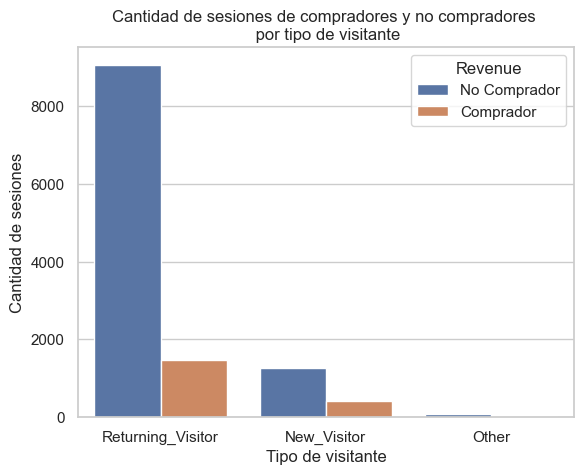

In [12]:
df_temp_3 = df_data.groupby(by=["VisitorType", "Revenue"], observed=False).count()["ProductRelated"].reset_index().rename(columns={"ProductRelated": "SessionCount"})
df_temp_3["Revenue"] = np.where(df_temp_3["Revenue"], "Comprador", "No Comprador")
display(df_temp_3)
sns.barplot(x="VisitorType", y="SessionCount", hue="Revenue", data=df_temp_3)
plt.ylabel("Cantidad de sesiones")
plt.xlabel("Tipo de visitante")
plt.title("Cantidad de sesiones de compradores y no compradores \n por tipo de visitante")
plt.show()

A simple vista se podría decir que los visitantes que regresan al sitio (*Returning_Visitor*) realizan más compras, pero para analizar esta información de forma objetiva es necesario manejar los valores a nivel porcentual para cada tipo de visitante y su clasificación de comprador o no comprador

,VisitorType,SessionPercentage_Buyer,SessionPercentage_NonBuyer
0,Returning_Visitor,13.95,86.05
1,New_Visitor,24.91,75.09
2,Other,18.82,81.18


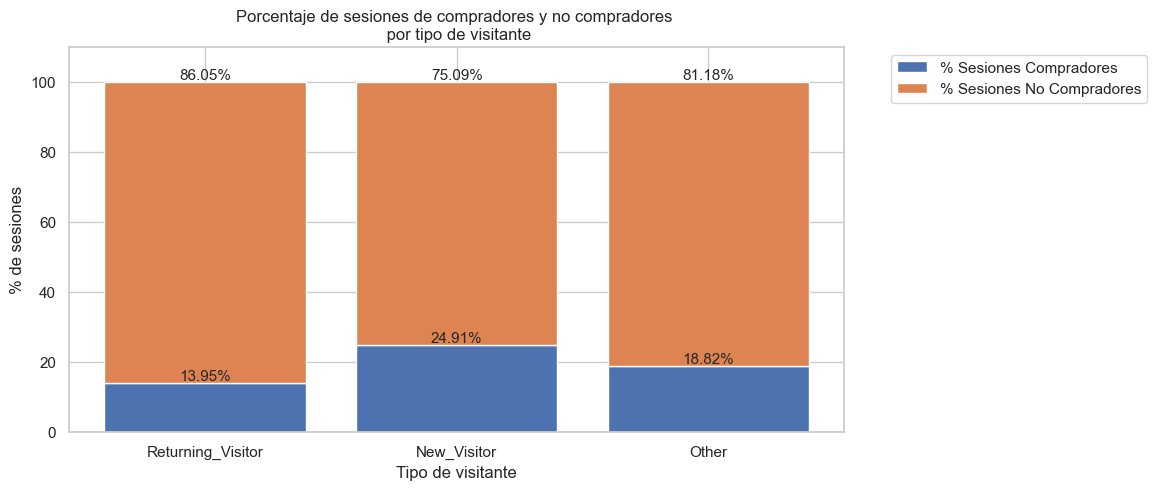

In [13]:
df_temp_4 = pd.DataFrame(df_data.groupby(by=["VisitorType", "Revenue"], observed=False)["ProductRelated"].count().reset_index().rename(columns={"ProductRelated":"SessionCount"}))
df_temp_4["Revenue"] = np.where(df_temp_4["Revenue"], "Comprador", "No Comprador")
df_temp_4.rename(columns={"Revenue": "Tipo de cliente"}, inplace=True)
df_temp_4 = pd.merge(df_temp_4, df_temp_4.groupby(by=["VisitorType"], observed=False).sum(numeric_only=True).reset_index().rename(columns={"SessionCount":"TotalSession"}), on=["VisitorType"], how="left")
df_temp_4["SessionPercentage"] = round((df_temp_4["SessionCount"] / df_temp_4["TotalSession"]) * 100, 2)
df_temp_4 = df_temp_4.pivot(index='VisitorType', columns='Tipo de cliente', values='SessionPercentage').reset_index()
df_temp_4.columns.name = None
df_temp_4.rename(columns={"Comprador":"SessionPercentage_Buyer", "No Comprador": "SessionPercentage_NonBuyer"}, inplace=True)
display(df_temp_4)
plt.figure(figsize=(10,5))

bars1 = plt.bar(df_temp_4["VisitorType"], df_temp_4["SessionPercentage_Buyer"], label="% Sesiones Compradores")
bars2 = plt.bar(df_temp_4["VisitorType"], df_temp_4["SessionPercentage_NonBuyer"], bottom = df_temp_4["SessionPercentage_Buyer"], label="% Sesiones No Compradores")

text_size = 11
for bar, value in zip(bars1, df_temp_4["SessionPercentage_Buyer"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

for bar, value in zip(bars2, df_temp_4["SessionPercentage_NonBuyer"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

plt.ylim(0,110)
plt.ylabel("% de sesiones")
plt.xlabel("Tipo de visitante")
plt.title("Porcentaje de sesiones de compradores y no compradores \n por tipo de visitante")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

A pesar que la cantidad de sesiones de visitantes que retornan al sitio es mayor estos en su mayoría no realizan compras, unicamente un 13.9% del total de Returning_Visitor realizan una compra en la página. Mientras que el 24.9% de nuevos visitantes realizan compras.

Esto permite concluir que la página influye más en la decisión de compra de nuevos visitantes que en la de visitantes antiguos.

### Google Analytics Metrics

Como parte del dataset se incluyen las métricas de *engagement* o compromiso. La intención del análisis a continuación es determinar la relación que mantienen estas métricas con la clasificación de la sesión del cliente como comprador o no comprador.

Se consideran las siguientes variables
* BounceRates
* ExitRates
* PageValues

#### ExitRates vs BounceRates

ExitRates: Por definición es una metrica que muestra el porcentaje de salidas desde una página. En este dataset mostrado en sesiones de usuario es el promedio de la *tasa de salida* de páginas visitadadas en cada sesión registrada

BounceRates: Por definicion es un métrica que muestra el porcentaje de visitantes que salieron del sitio después de visitar solo una página. En este dataset mostrado en sesiones es el promedio de la *tasa de rebote* de las páginas visitada por el usuario durante la sesión

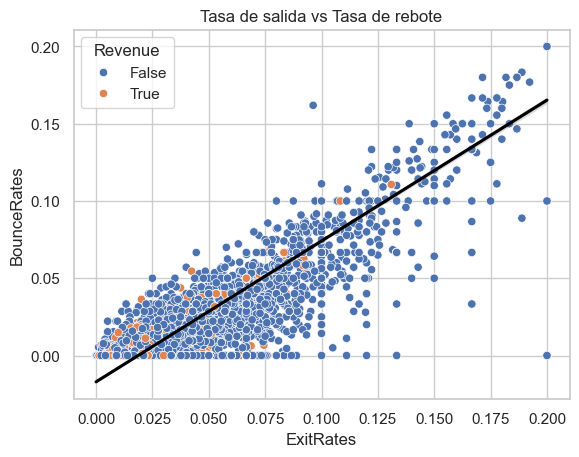

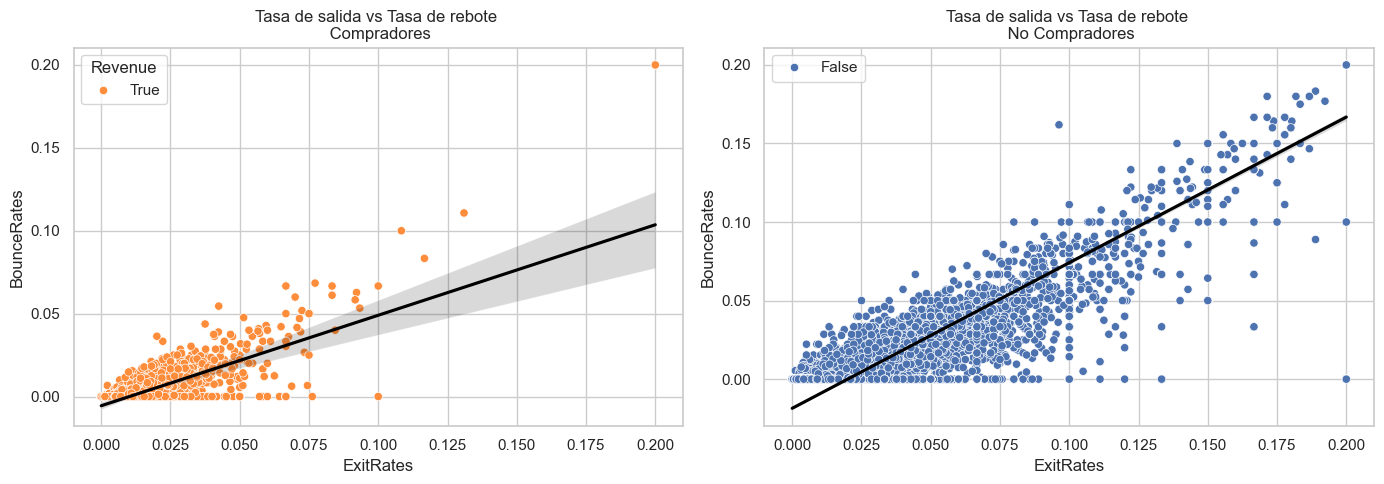

In [16]:
sns.scatterplot(data=df_data, x="ExitRates", y="BounceRates", hue="Revenue")
sns.regplot(data=df_data, x="ExitRates", y="BounceRates", scatter=False, color="Black")
plt.title("Tasa de salida vs Tasa de rebote")


fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.scatterplot(data=df_data[df_data["Revenue"]], x="ExitRates", y="BounceRates", hue="Revenue", ax=axes[0], palette="Oranges")
sns.regplot(data=df_data[df_data["Revenue"]], x="ExitRates", y="BounceRates", scatter=False, color="Black", ax=axes[0])
axes[0].set_title("Tasa de salida vs Tasa de rebote \n Compradores")

sns.scatterplot(data=df_data[~df_data["Revenue"]], x="ExitRates", y="BounceRates", hue="Revenue", ax=axes[1])
sns.regplot(data=df_data[~df_data["Revenue"]], x="ExitRates", y="BounceRates", scatter=False, color="Black", ax=axes[1])
axes[1].set_title("Tasa de salida vs Tasa de rebote \n No Compradores")

plt.legend()
plt.tight_layout()
plt.show()

Los gráficos de puntos muestran una correlación positiva entre *ExitRates* y *BounceRates* es decir, a mayor tasa da salida mayor tasa de rebote. 

Para determinar si estas variables mantienen relación con la influencia de compra se realiza el segundo gráfico separando las sesiones que culminan con una compra y las sesiones que no. A la izquierda en color naranja se muestran las sesiones de clientes que compraron. Este gráfico confirma la correlación positiva de las variables y permite concluir que valores bajos en ambas variables (tasa de salida y rebote) son indicativos de una compra.